In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from scipy.stats import kruskal
from scipy.stats import zscore

In [126]:
train_label = "./data/engineered/train/train_label_engineered.csv"
train_merged = "./data/engineered/train/merged_engineered.csv"
test_label = "./data/engineered/validation/validation_label_engineered.csv"
test_sleep = "./data/engineered/validation/merged_engineered.csv"

train_merged = pd.read_csv(train_merged)
train_label = pd.read_csv(train_label)

In [127]:
label_df = train_label.rename(columns={"SAMPLE_EMAIL": "EMAIL"})
label_df = label_df[label_df["DIAG_NM"].isin(["CN", "MCI", "Dem"])]
df = pd.merge(train_merged, label_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="inner")

# sleep_restless

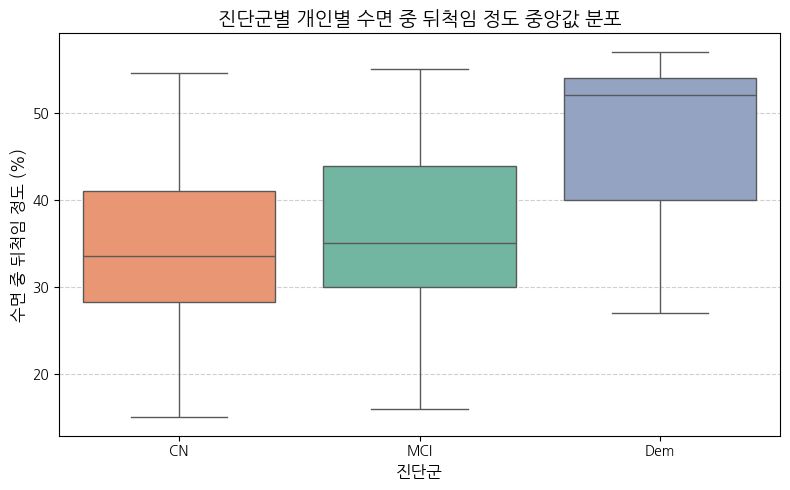

In [128]:
sleep_restless_median = (
    df.groupby("EMAIL")["sleep_restless"]
    .median()
    .reset_index(name="median_sleep_restless")
)

sleep_restless_median = sleep_restless_median.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL", how="left"
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=sleep_restless_median,
    x="DIAG_NM",
    y="median_sleep_restless",
    order=["CN", "MCI", "Dem"],
    hue="DIAG_NM",
    palette="Set2"
)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ Í∞úÏù∏Î≥Ñ ÏàòÎ©¥ Ï§ë Îí§Ï≤ôÏûÑ Ï†ïÎèÑ Ï§ëÏïôÍ∞í Î∂ÑÌè¨", fontsize=14)
plt.xlabel("ÏßÑÎã®Íµ∞", fontsize=12)
plt.ylabel("ÏàòÎ©¥ Ï§ë Îí§Ï≤ôÏûÑ Ï†ïÎèÑ (%)", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

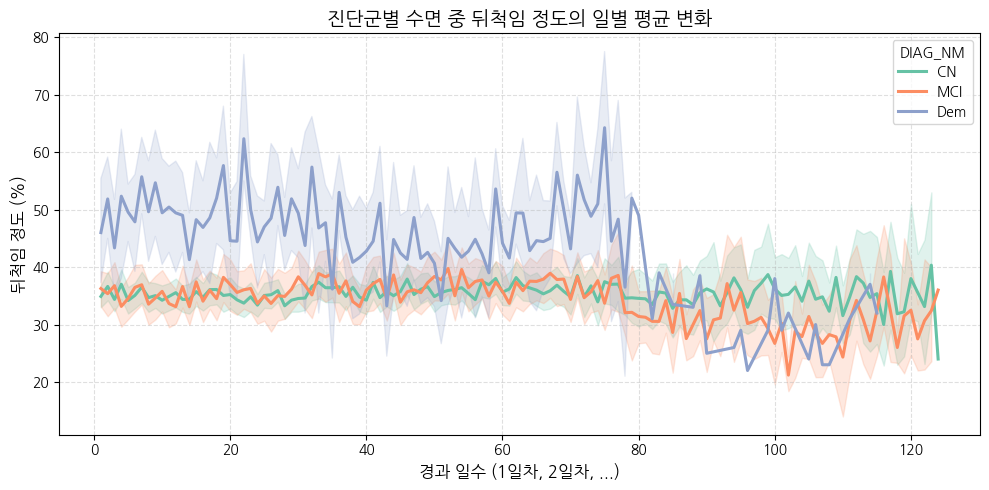

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_restless_by_day(df, time_col="sleep_bedtime_start", restless_col="sleep_restless", group_col="DIAG_NM"):
    df = df.copy()
    
    # 1Ô∏è‚É£ ÎÇ†Ïßú Í∏∞Ï§Ä Ï†ïÎ†¨ Î∞è Í≤ΩÍ≥ºÏùº Í≥ÑÏÇ∞
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(by=[group_col, "EMAIL", time_col])
    
    # ÏÇ¨ÎûåÎ≥Ñ Ï≤´ÎÇ† Í∏∞Ï§ÄÏúºÎ°ú Í≤ΩÍ≥ºÏùº(day index) Í≥ÑÏÇ∞
    df["day_index"] = df.groupby("EMAIL")[time_col].transform(lambda x: (x - x.min()).dt.days + 1)

    # 2Ô∏è‚É£ ÏßÑÎã®Íµ∞Î≥Ñ ÌèâÍ∑† ÏÑ† Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=df,
        x="day_index",
        y=restless_col,
        hue=group_col,
        estimator="mean",
        errorbar="ci",
        palette="Set2",
        linewidth=2.2,
        hue_order=['CN', 'MCI', 'Dem']
    )
    plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÏàòÎ©¥ Ï§ë Îí§Ï≤ôÏûÑ Ï†ïÎèÑÏùò ÏùºÎ≥Ñ ÌèâÍ∑† Î≥ÄÌôî", fontsize=14)
    plt.xlabel("Í≤ΩÍ≥º ÏùºÏàò (1ÏùºÏ∞®, 2ÏùºÏ∞®, ...)", fontsize=12)
    plt.ylabel("Îí§Ï≤ôÏûÑ Ï†ïÎèÑ (%)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
plot_restless_by_day(df)

# sleep Îã®Í≥Ñ ÎπÑÏú®

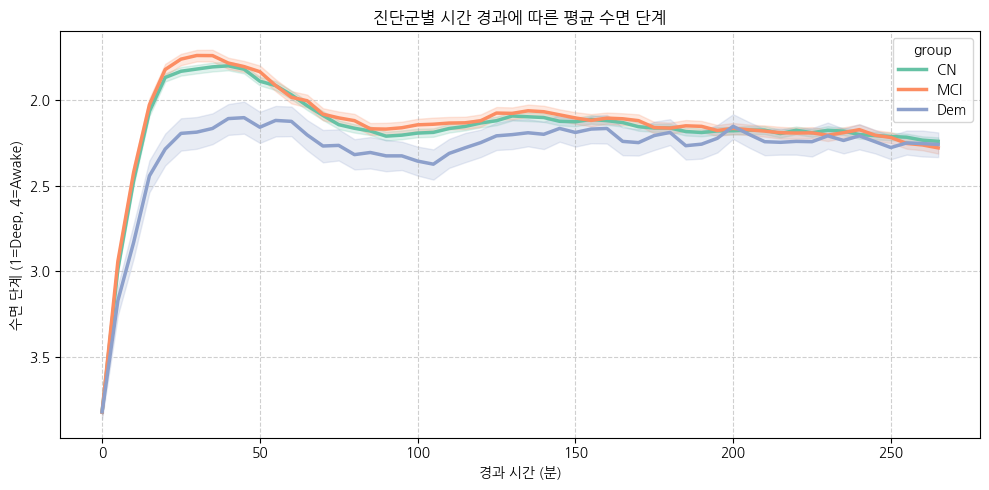

In [130]:
# Í∞Å Í∑∏Î£πÏóêÏÑú nÎ™ÖÏî© ÏÉòÌîåÎßÅÌïòÏó¨ ÌèâÍ∑† ÏàòÎ©¥ Îã®Í≥Ñ ÏãúÍ≥ÑÏó¥ Í≥ÑÏÇ∞
def plot_group_avg_sleep_stage(df, stage_col="sleep_hypnogram_5min", group_col="DIAG_NM", time_steps=54):
    records = []
    for _, row in df.iterrows():
        group = row[group_col]
        raw = row[stage_col]
        if isinstance(raw, str):
            stages = [int(x) for x in raw.split("/") if x.isdigit()]
            if len(stages) >= time_steps:
                for i in range(time_steps):
                    records.append({"minute": i*5, "stage": stages[i], "group": group})

    plot_df = pd.DataFrame(records)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=plot_df,
        x="minute", y="stage", hue="group",
        estimator="mean", errorbar="ci", linewidth=2.5,
        hue_order=["CN", "MCI", "Dem"],
        palette='Set2'
    )
    plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÏãúÍ∞Ñ Í≤ΩÍ≥ºÏóê Îî∞Î•∏ ÌèâÍ∑† ÏàòÎ©¥ Îã®Í≥Ñ")
    plt.xlabel("Í≤ΩÍ≥º ÏãúÍ∞Ñ (Î∂Ñ)")
    plt.ylabel("ÏàòÎ©¥ Îã®Í≥Ñ (1=Deep, 4=Awake)")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_group_avg_sleep_stage(df)

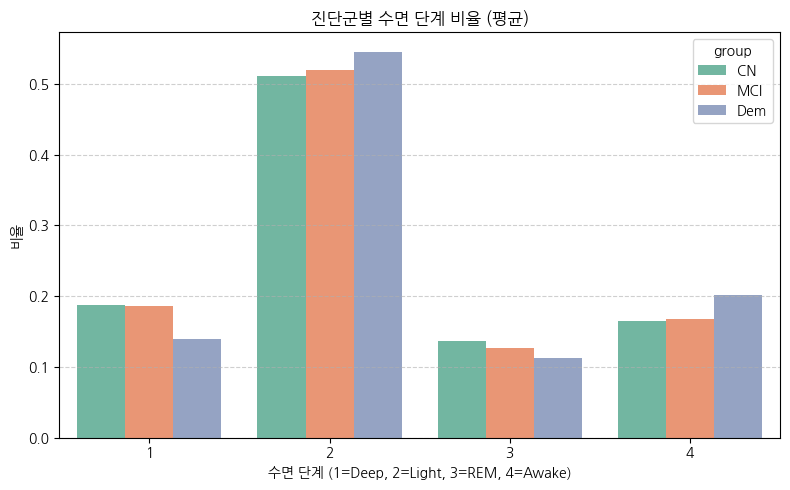

In [131]:
# ÎπÑÏú®Î°ú Î≥ÄÌôò ÌõÑ ÏãúÍ∞ÅÌôî
def plot_stage_ratio_bar(df, stage_col="sleep_hypnogram_5min", group_col="DIAG_NM"):
    records = []

    for _, row in df.iterrows():
        group = row[group_col]
        raw = row[stage_col]
        if isinstance(raw, str):
            stages = [int(x) for x in raw.split("/") if x.isdigit()]
            total = len(stages)
            if total > 0:
                for s in [1, 2, 3, 4]:
                    ratio = stages.count(s) / total
                    records.append({"group": group, "stage": s, "ratio": ratio})

    stage_df = pd.DataFrame(records)
    stage_df = stage_df.groupby(["group", "stage"])["ratio"].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=stage_df, x="stage", y="ratio", hue="group", palette="Set2", hue_order=['CN', 'MCI', 'Dem'])
    plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÏàòÎ©¥ Îã®Í≥Ñ ÎπÑÏú® (ÌèâÍ∑†)")
    plt.xlabel("ÏàòÎ©¥ Îã®Í≥Ñ (1=Deep, 2=Light, 3=REM, 4=Awake)")
    plt.ylabel("ÎπÑÏú®")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_stage_ratio_bar(df)

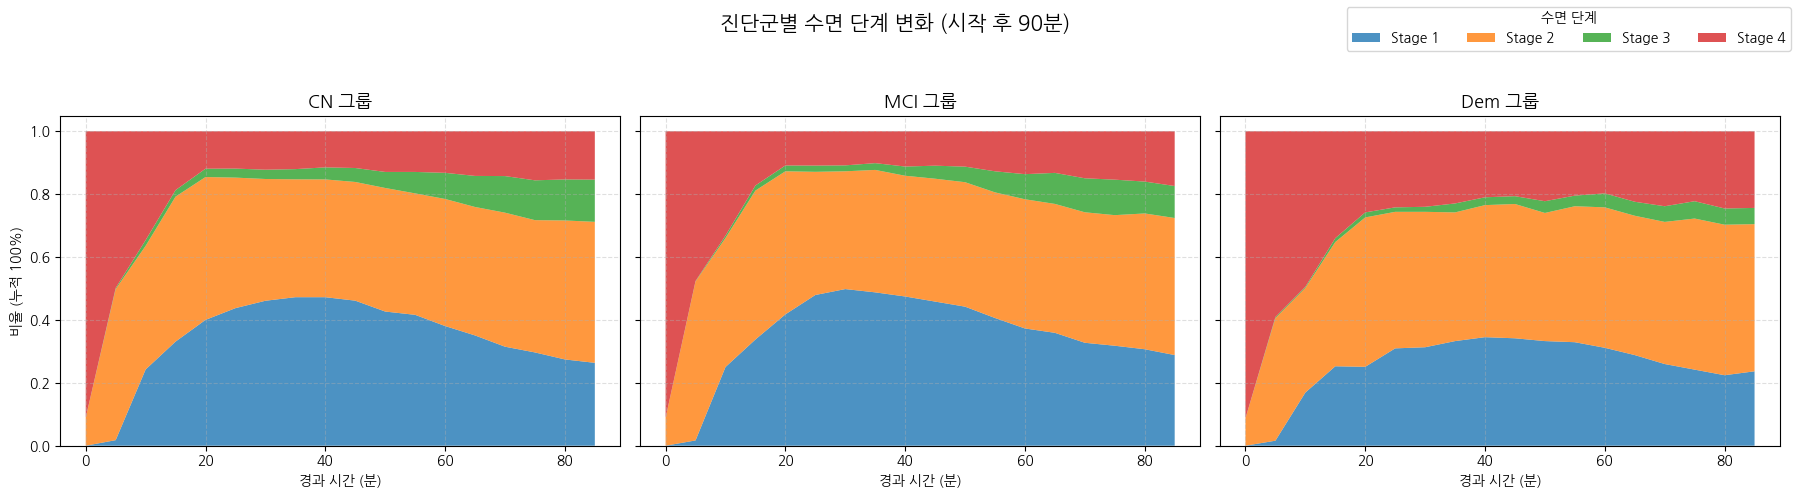

In [132]:
def plot_sleep_stage_stacked_area_row(df, stage_col="sleep_hypnogram_5min", group_col="DIAG_NM", max_steps=18):
    records = []

    for _, row in df.iterrows():
        group = row[group_col]
        raw = row[stage_col]

        if isinstance(raw, str):
            stages = [int(x) for x in raw.split("/") if x.isdigit()]
            if len(stages) >= max_steps:
                stages = stages[:max_steps]
                for i, s in enumerate(stages):
                    records.append({
                        "group": group,
                        "minute": i * 5,
                        "stage": s
                    })

    long_df = pd.DataFrame(records)

    # ÎπÑÏú® Í≥ÑÏÇ∞
    counts = (
        long_df
        .groupby(["group", "minute", "stage"])
        .size()
        .reset_index(name="count")
    )

    counts["total"] = counts.groupby(["group", "minute"])["count"].transform("sum")
    counts["pct"] = counts["count"] / counts["total"]

    # Í∑∏Î£π Î¶¨Ïä§Ìä∏ Ï†ïÎ†¨
    group_list = ["CN", "MCI", "Dem"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, group in zip(axes, group_list):
        group_df = counts[counts["group"] == group]
        pivot_df = group_df.pivot(index="minute", columns="stage", values="pct").fillna(0)
        pivot_df = pivot_df[sorted(pivot_df.columns)]  # 1,2,3,4 ÏàúÏÑú Î≥¥Ïû•

        ax.stackplot(
            pivot_df.index,
            [pivot_df[s] for s in pivot_df.columns],
            labels=[f"Stage {s}" for s in pivot_df.columns],
            alpha=0.8
        )
        ax.set_title(f"{group} Í∑∏Î£π", fontsize=13)
        ax.set_xlabel("Í≤ΩÍ≥º ÏãúÍ∞Ñ (Î∂Ñ)")
        ax.grid(True, linestyle="--", alpha=0.4)

    axes[0].set_ylabel("ÎπÑÏú® (ÎàÑÏ†Å 100%)")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="ÏàòÎ©¥ Îã®Í≥Ñ", loc="upper right", ncol=4)
    fig.suptitle("ÏßÑÎã®Íµ∞Î≥Ñ ÏàòÎ©¥ Îã®Í≥Ñ Î≥ÄÌôî (ÏãúÏûë ÌõÑ 90Î∂Ñ)", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_sleep_stage_stacked_area_row(df)

In [133]:
person_day_pct = df.copy()
person_day_pct["stage_list"] = df["sleep_hypnogram_5min"].apply(lambda s: [int(x) for x in s.split("/") if x.isdigit()])

In [134]:
from scipy.stats import entropy

# 1Ïùº Îã®ÏúÑ ÏàòÎ©¥ ÏóîÌä∏Î°úÌîº
def calc_entropy(stage_list):
    counts = pd.Series(stage_list).value_counts(normalize=True)
    return entropy(counts)

person_day_pct["entropy"] = person_day_pct["stage_list"].apply(calc_entropy)

# ÏÇ¨ÎûåÎ≥Ñ ÏàòÎ©¥ ÏóîÌä∏Î°úÌîºÏùò ÌëúÏ§ÄÌé∏Ï∞®
entropy_std_df = (
    person_day_pct.groupby("EMAIL")["entropy"]
    .std()
    .reset_index(name="std_entropy")
)

- ÏàòÎ©¥Îã®Í≥Ñ Î≥Ñ ÎπÑÏú®Ïù¥ ÏùºÍ¥ÄÏ†ÅÏù∏ÏßÄ

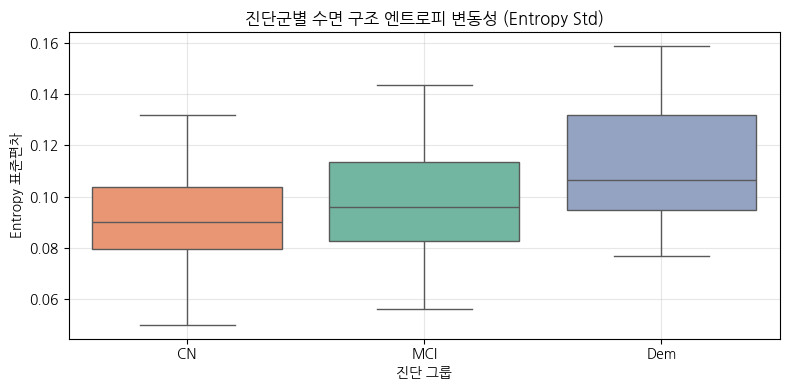

In [135]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=entropy_std_df.merge(df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL"),
    x="DIAG_NM", y="std_entropy", order=["CN", "MCI", "Dem"],
    palette="Set2", showfliers=False, hue='DIAG_NM'
)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÏàòÎ©¥ Íµ¨Ï°∞ ÏóîÌä∏Î°úÌîº Î≥ÄÎèôÏÑ± (Entropy Std)")
plt.xlabel("ÏßÑÎã® Í∑∏Î£π")
plt.ylabel("Entropy ÌëúÏ§ÄÌé∏Ï∞®")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# rmssd

In [136]:
import ast

def parse_rmssd_list(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) else []
    except:
        return []
    
df['rmssd_list'] = df['sleep_rmssd_5min_interpolated'].apply(parse_rmssd_list)

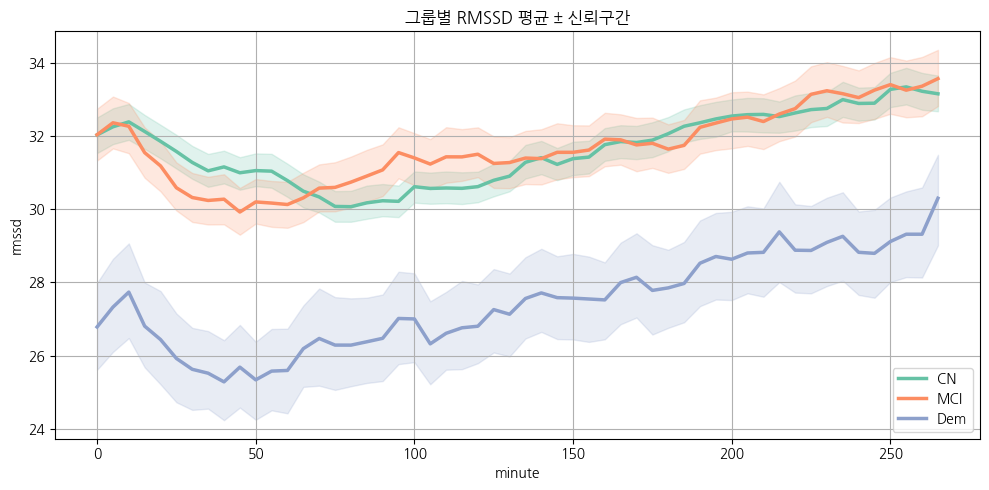

In [137]:
def plot_group_mean_with_ci(df, rmssd_col="rmssd_list", group_col="DIAG_NM", time_steps=54):
    rows = []

    for _, row in df.iterrows():
        series = row[rmssd_col]
        group = row[group_col]

        if isinstance(series, list) and len(series) >= time_steps:
            for i in range(time_steps):
                rows.append({
                    "minute": i * 5,
                    "rmssd": series[i],
                    "group": group
                })

    long_df = pd.DataFrame(rows)

    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=long_df, x="minute", y="rmssd",
        hue="group", errorbar="ci", hue_order=["CN", "MCI", "Dem"],
        estimator="mean", linewidth=2.5, palette='Set2'
    )
    plt.title("Í∑∏Î£πÎ≥Ñ RMSSD ÌèâÍ∑† ¬± Ïã†Î¢∞Íµ¨Í∞Ñ")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_group_mean_with_ci(df)

- rmssd Í∞íÏù¥ ÎÜíÏùÑÏàòÎ°ù Ïã¨Î∞ï Î≥ÄÎèôÏÑ±Ïù¥ ÌÅ¨Í≥†, ÏûêÏú®Ïã†Í≤ΩÍ≥ÑÍ∞Ä Ïûò Ï°∞Ï†àÎêòÍ≥† ÏûàÎäî ÏÉÅÌÉúÎ•º ÏùòÎØ∏
- Ï¥àÎ∞ò 10Î∂ÑÏóêÏÑú 70Î∂Ñ ÏÇ¨Ïù¥Ïóê Dem < MCI < CN ÏàúÏúºÎ°ú RMSSDÍ∞Ä ÏûëÏùå

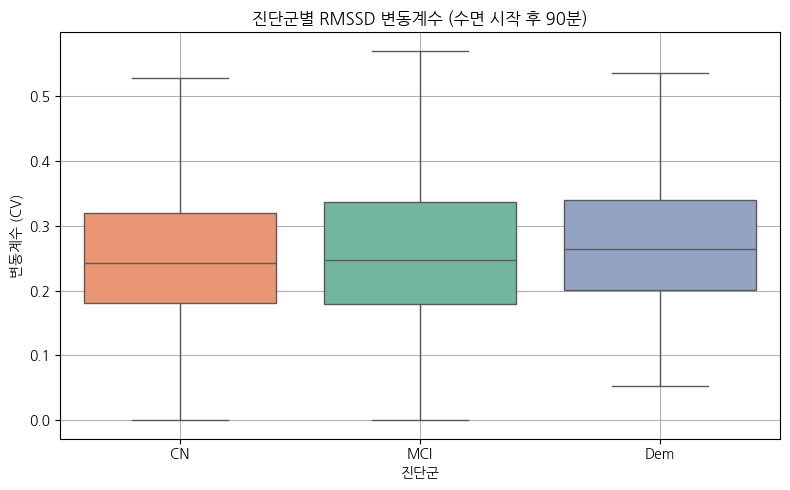

In [138]:
def compute_rmssd_cv_95min(df, rmssd_col="rmssd_list", group_col="DIAG_NM", time_steps=18):
    df = df.copy()
    df["rmssd_cv_90min"] = df[rmssd_col].apply(
        lambda x: np.std(x[:time_steps]) / np.mean(x[:time_steps]) if isinstance(x, list) and len(x) >= time_steps and np.mean(x[:time_steps]) != 0 else np.nan
    )
    return df

# Ï†ÅÏö©
df = compute_rmssd_cv_95min(df)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="DIAG_NM", y="rmssd_cv_90min", 
            order=["CN", "MCI", "Dem"], hue='DIAG_NM',
            palette='Set2', showfliers=False)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ RMSSD Î≥ÄÎèôÍ≥ÑÏàò (ÏàòÎ©¥ ÏãúÏûë ÌõÑ 90Î∂Ñ)")
plt.xlabel("ÏßÑÎã®Íµ∞")
plt.ylabel("Î≥ÄÎèôÍ≥ÑÏàò (CV)")
plt.grid(True)
plt.tight_layout()
plt.show()

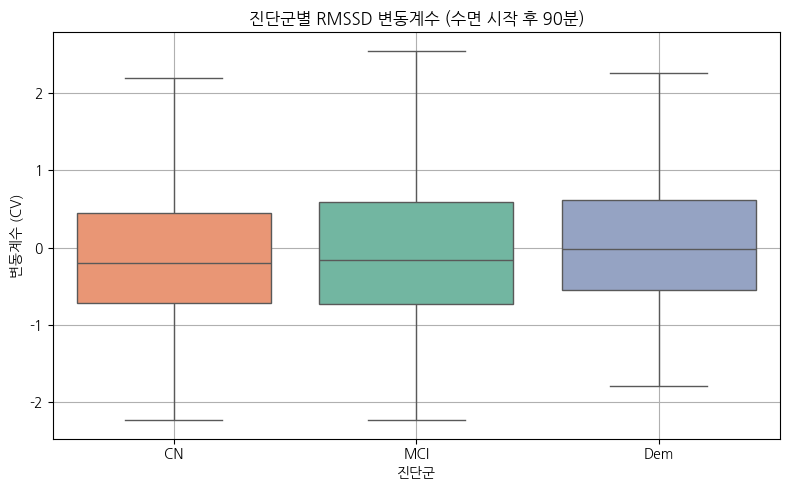

In [140]:
# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="DIAG_NM", y="rmssd_cv_90min_z", 
            order=["CN", "MCI", "Dem"], hue='DIAG_NM',
            palette='Set2', showfliers=False)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ RMSSD Î≥ÄÎèôÍ≥ÑÏàò (ÏàòÎ©¥ ÏãúÏûë ÌõÑ 90Î∂Ñ)")
plt.xlabel("ÏßÑÎã®Íµ∞")
plt.ylabel("Î≥ÄÎèôÍ≥ÑÏàò (CV)")
plt.grid(True)
plt.tight_layout()
plt.show()

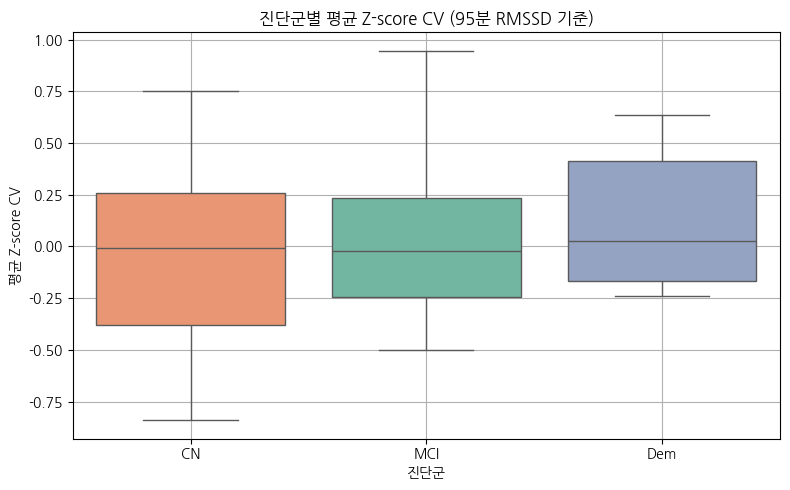

In [139]:
# 1. Ï†ÑÏ≤¥ÏóêÏÑú Z-score Í≥ÑÏÇ∞
df["rmssd_cv_90min_z"] = zscore(df["rmssd_cv_90min"].dropna())

# 2. EMAIL Îã®ÏúÑÎ°ú ÌèâÍ∑† Z-score Í≥ÑÏÇ∞
person_cv_zscore_df = df.groupby("EMAIL")["rmssd_cv_90min_z"].mean().reset_index()
person_cv_zscore_df.rename(columns={"rmssd_cv_90min_z": "mean_zscore_cv_90min"}, inplace=True)

df = pd.merge(df, person_cv_zscore_df, on="EMAIL", how="left")
# ÏãúÍ∞ÅÌôîÏö© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Íµ¨ÏÑ±
plot_df = df[["EMAIL", "DIAG_NM", "mean_zscore_cv_90min"]].drop_duplicates()

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x="DIAG_NM", y="mean_zscore_cv_90min", hue='DIAG_NM',
            order=["CN", "MCI", "Dem"], palette='Set2', showfliers=False)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÌèâÍ∑† Z-score CV (95Î∂Ñ RMSSD Í∏∞Ï§Ä)")
plt.xlabel("ÏßÑÎã®Íµ∞")
plt.ylabel("ÌèâÍ∑† Z-score CV")
plt.grid(True)
plt.tight_layout()
plt.show()

Î≥ÄÎèôÍ≥ÑÏàò(CV) = $(std) / (mean)$

- ÏÉÅÎåÄÏ†ÅÏù∏ ÏïàÏ†ïÏÑ±ÏùÑ ÎÇòÌÉÄÎÉÑ

üìä Kruskal-Wallis Test for sleep_rmssd_median
  Statistic = 32.3196, p-value = 9.5915e-08
üìä Kruskal-Wallis Test for rmssd_median_20_70min
  Statistic = 88.2241, p-value = 6.9562e-20


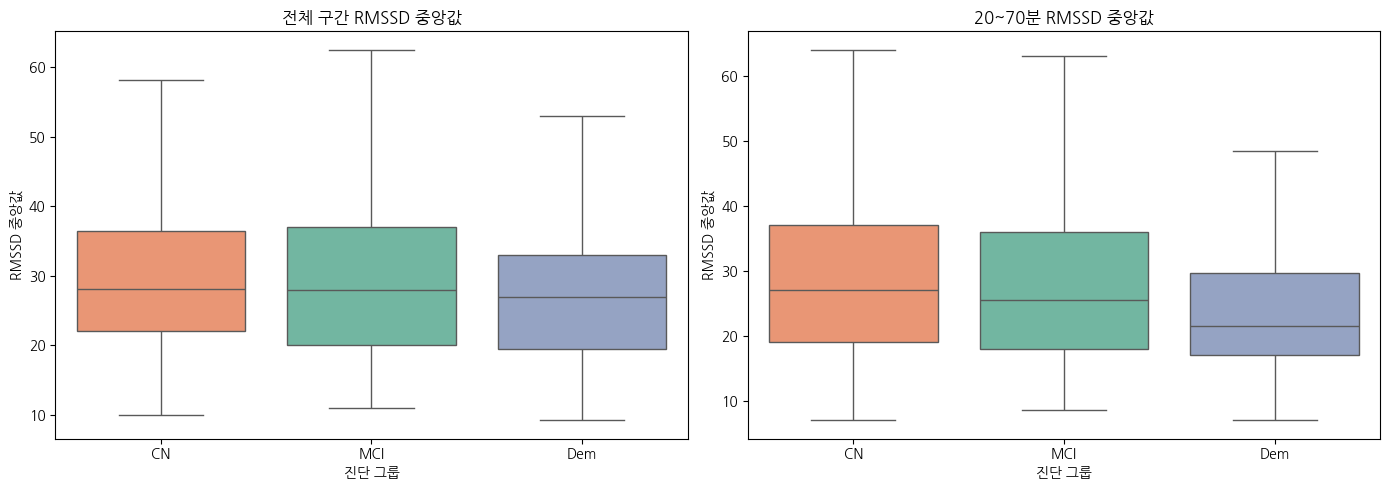

In [95]:
# -------------------------
# 1. 20~70Î∂Ñ ÏÇ¨Ïù¥ median Í≥ÑÏÇ∞ Ìï®Ïàò
# -------------------------
def compute_segment_median(row, rmssd_col="rmssd_list", start_idx=4, end_idx=13):
    data = row[rmssd_col]
    if isinstance(data, list) and len(data) > end_idx:
        return np.median(data[start_idx:end_idx+1])
    return np.nan

# -------------------------
# 2. Feature ÏÉùÏÑ±
# -------------------------
df["rmssd_median_20_70min"] = df.apply(compute_segment_median, axis=1)

# -------------------------
# 3. Kruskal-Wallis Í≤ÄÏ†ï
# -------------------------
def kruskal_test_by_group(df, value_col):
    grouped = df.dropna(subset=[value_col]).groupby("DIAG_NM")[value_col]
    groups = [group for name, group in grouped]
    stat, p = kruskal(*groups)
    print(f"üìä Kruskal-Wallis Test for {value_col}")
    print(f"  Statistic = {stat:.4f}, p-value = {p:.4e}")

# Ï†ÑÏ≤¥ RMSSD median Í≤ÄÏ†ï
kruskal_test_by_group(df, "sleep_rmssd_median")

# 20~70Î∂Ñ median Í≤ÄÏ†ï
kruskal_test_by_group(df, "rmssd_median_20_70min")

# -------------------------
# 4. ÏãúÍ∞ÅÌôî
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x="DIAG_NM", y="sleep_rmssd_median",
            order=["CN", "MCI", "Dem"], ax=axes[0], 
            hue='DIAG_NM',
            palette="Set2", showfliers=False)
axes[0].set_title("Ï†ÑÏ≤¥ Íµ¨Í∞Ñ RMSSD Ï§ëÏïôÍ∞í")
axes[0].set_xlabel("ÏßÑÎã® Í∑∏Î£π")
axes[0].set_ylabel("RMSSD Ï§ëÏïôÍ∞í")

sns.boxplot(data=df, x="DIAG_NM", y="rmssd_median_20_70min",
            order=["CN", "MCI", "Dem"], ax=axes[1], 
            hue='DIAG_NM',
            palette="Set2", showfliers=False)
axes[1].set_title("20~70Î∂Ñ RMSSD Ï§ëÏïôÍ∞í")
axes[1].set_xlabel("ÏßÑÎã® Í∑∏Î£π")
axes[1].set_ylabel("RMSSD Ï§ëÏïôÍ∞í")

plt.tight_layout()
plt.show()

‚¨ÜÔ∏è Ï†ÑÏ≤¥ Íµ¨Í∞ÑÏùò Ï§ëÏïôÍ∞íÎ≥¥Îã§ 20Î∂Ñ-70Î∂Ñ ÏÇ¨Ïù¥Ïùò rmssd Ï§ëÏïôÍ∞í Ï∞®Ïù¥Í∞Ä Îçî ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÏùòÎØ∏Í∞Ä ÏûàÏùå

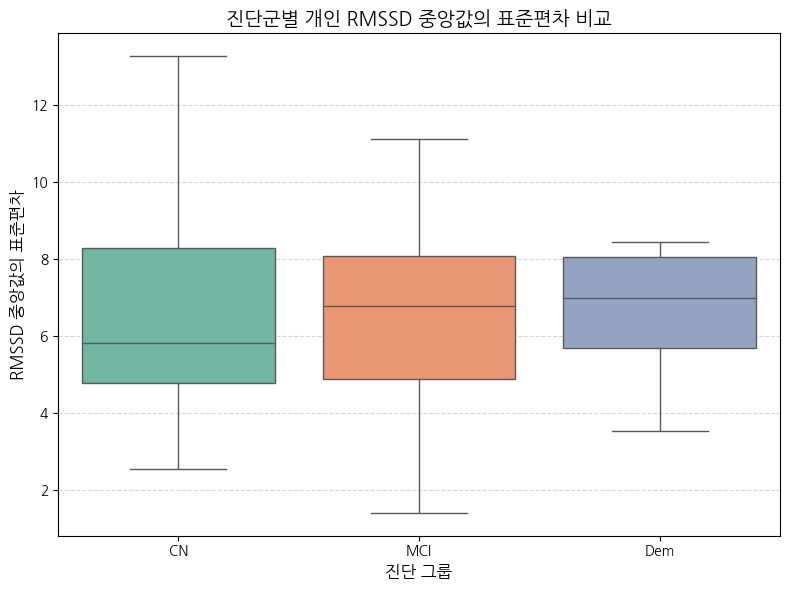

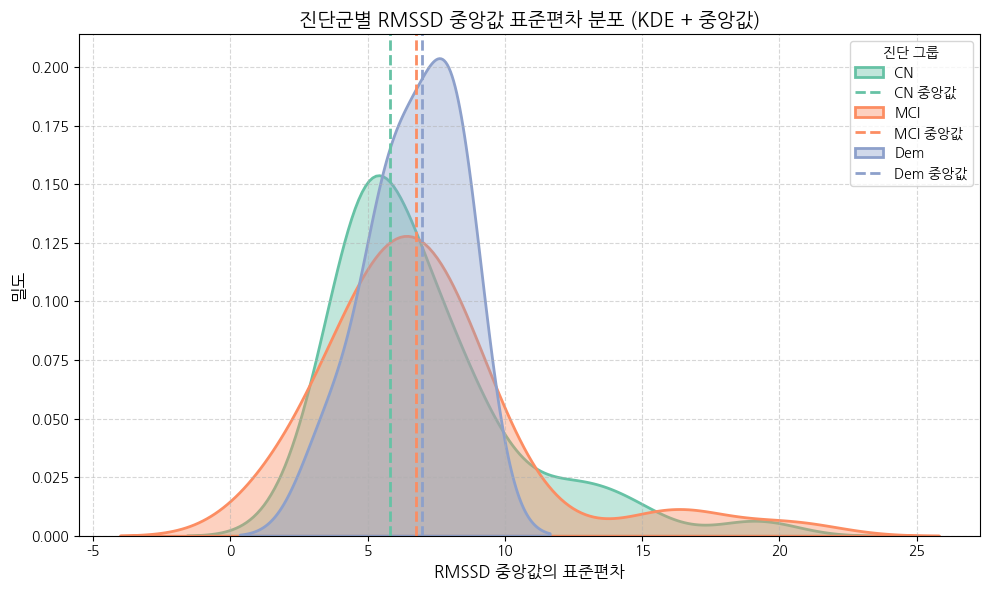

In [147]:
email_rmssd_max_median = df.groupby("EMAIL").agg({
    "sleep_rmssd_median": "std",
    "DIAG_NM": "first"
}).reset_index()

import matplotlib.cm as cm

# üé® Set2 ÌåîÎ†àÌä∏
palette = dict(zip(["CN", "MCI", "Dem"], sns.color_palette("Set2", 3)))

# üì¶ Boxplot ÏãúÍ∞ÅÌôî (RMSSD Ï§ëÏïôÍ∞íÏùò ÌëúÏ§ÄÌé∏Ï∞®)
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=email_rmssd_max_median,
    x="DIAG_NM",
    y="sleep_rmssd_median",
    palette=palette,
    hue='DIAG_NM',
    order=["CN", "MCI", "Dem"],
    showfliers=False
)
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ Í∞úÏù∏ RMSSD Ï§ëÏïôÍ∞íÏùò ÌëúÏ§ÄÌé∏Ï∞® ÎπÑÍµê", fontsize=14)
plt.xlabel("ÏßÑÎã® Í∑∏Î£π", fontsize=12)
plt.ylabel("RMSSD Ï§ëÏïôÍ∞íÏùò ÌëúÏ§ÄÌé∏Ï∞®", fontsize=12)
plt.grid(True, axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# üé® KDE ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
for group in ["CN", "MCI", "Dem"]:
    subset = email_rmssd_max_median[email_rmssd_max_median["DIAG_NM"] == group]["sleep_rmssd_median"].dropna()
    
    sns.kdeplot(
        data=subset,
        label=group,
        fill=True,
        color=palette[group],
        alpha=0.4,
        linewidth=2
    )

    median_val = subset.median()
    plt.axvline(median_val, color=palette[group], linestyle="--", linewidth=2, label=f"{group} Ï§ëÏïôÍ∞í")

plt.title("ÏßÑÎã®Íµ∞Î≥Ñ RMSSD Ï§ëÏïôÍ∞í ÌëúÏ§ÄÌé∏Ï∞® Î∂ÑÌè¨ (KDE + Ï§ëÏïôÍ∞í)", fontsize=14)
plt.xlabel("RMSSD Ï§ëÏïôÍ∞íÏùò ÌëúÏ§ÄÌé∏Ï∞®", fontsize=12)
plt.ylabel("Î∞ÄÎèÑ", fontsize=12)
plt.legend(title="ÏßÑÎã® Í∑∏Î£π")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- RMSSD ÏãúÍ≥ÑÏó¥ÏóêÏÑú Ìå®ÌÑ¥Ïùò ÏùºÍ¥ÄÏÑ± Ï†ÄÌïò

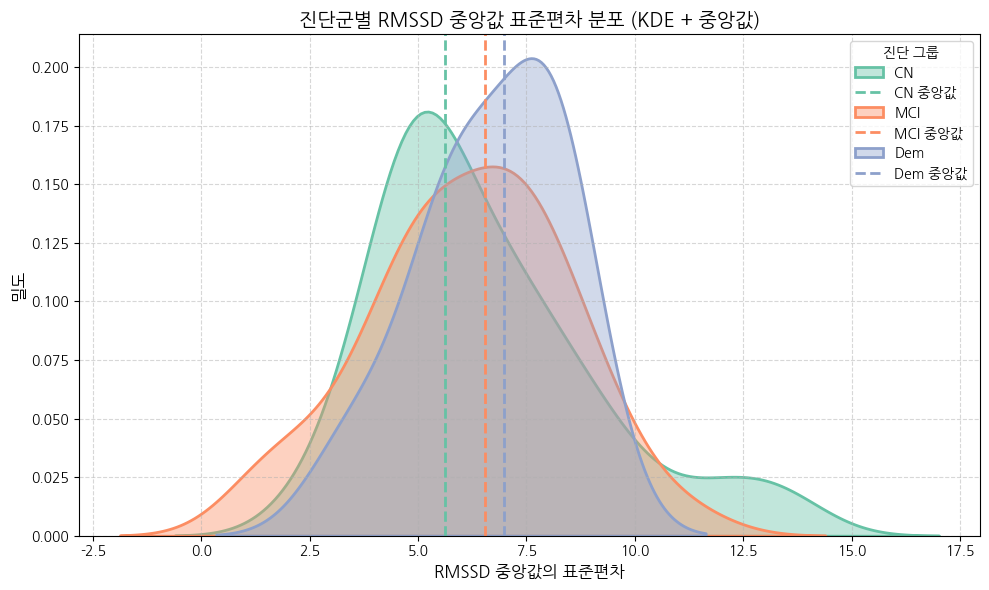

In [150]:
threshold = email_rmssd_max_median["sleep_rmssd_median"].quantile(0.95)
filtered_df = email_rmssd_max_median[email_rmssd_max_median["sleep_rmssd_median"] <= threshold]

plt.figure(figsize=(10, 6))
for group in ["CN", "MCI", "Dem"]:
    subset = filtered_df[filtered_df["DIAG_NM"] == group]["sleep_rmssd_median"].dropna()
    
    sns.kdeplot(
        data=subset,
        label=group,
        fill=True,
        color=palette[group],
        alpha=0.4,
        linewidth=2
    )

    median_val = subset.median()
    plt.axvline(median_val, color=palette[group], linestyle="--", linewidth=2, label=f"{group} Ï§ëÏïôÍ∞í")

plt.title("ÏßÑÎã®Íµ∞Î≥Ñ RMSSD Ï§ëÏïôÍ∞í ÌëúÏ§ÄÌé∏Ï∞® Î∂ÑÌè¨ (KDE + Ï§ëÏïôÍ∞í)", fontsize=14)
plt.xlabel("RMSSD Ï§ëÏïôÍ∞íÏùò ÌëúÏ§ÄÌé∏Ï∞®", fontsize=12)
plt.ylabel("Î∞ÄÎèÑ", fontsize=12)
plt.legend(title="ÏßÑÎã® Í∑∏Î£π")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- 95th percentile Ïù¥ÏÉÅ Ï†úÍ±∞(ÏÉÅÏúÑ Ïù¥ÏÉÅÏπò Ï†úÍ±∞)

# activity_inactive

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


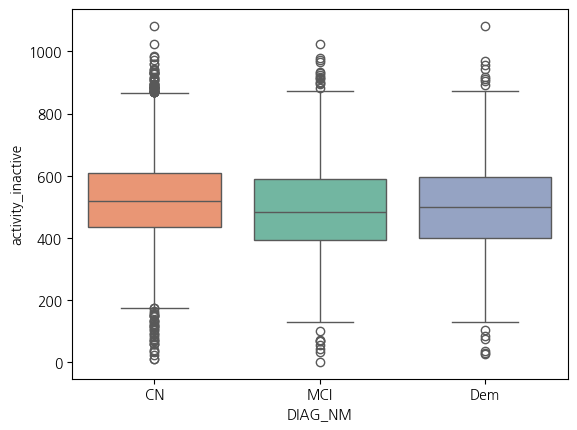

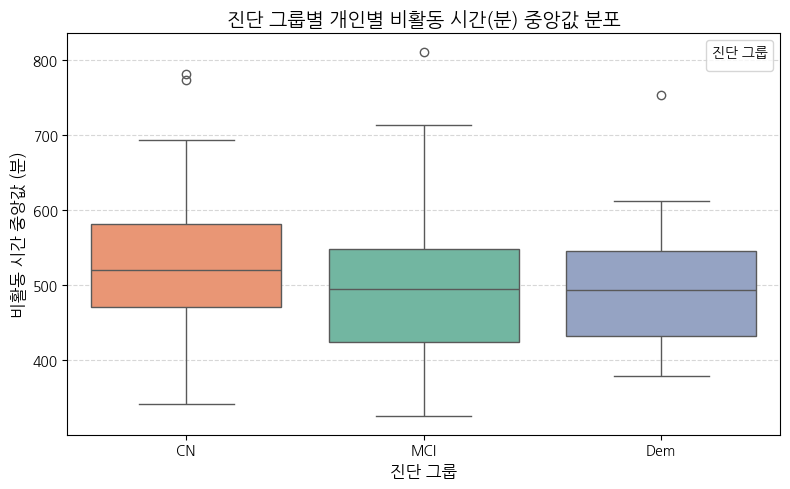

In [152]:
sns.boxplot(data=df, x='DIAG_NM', hue='DIAG_NM', palette='Set2',
            y='activity_inactive', order=['CN', 'MCI', 'Dem'])

activity_inactive_median = (
    df.groupby("EMAIL")["activity_inactive"]
    .median()
    .reset_index(name="median_activity_inactive")
)

# 2. ÏßÑÎã®Î™Ö Î≥ëÌï©
activity_inactive_median = activity_inactive_median.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL", how="left"
)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=activity_inactive_median,
    x="DIAG_NM",
    y="median_activity_inactive",
    order=["CN", "MCI", "Dem"],
    hue="DIAG_NM",
    palette="Set2"
)

plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ Í∞úÏù∏Î≥Ñ ÎπÑÌôúÎèô ÏãúÍ∞Ñ(Î∂Ñ) Ï§ëÏïôÍ∞í Î∂ÑÌè¨", fontsize=14)
plt.xlabel("ÏßÑÎã® Í∑∏Î£π", fontsize=12)
plt.ylabel("ÎπÑÌôúÎèô ÏãúÍ∞Ñ Ï§ëÏïôÍ∞í (Î∂Ñ)", fontsize=12)
plt.legend(title="ÏßÑÎã® Í∑∏Î£π")
plt.grid(True, axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

activity_class_5min	ÌïòÎ£®Í∞Ñ 5Î∂Ñ Îãπ ÌôúÎèô Î°úÍ∑∏	
'0' = non-wear
'1'=rest(MET level below 1.05)
'2'=inactive(MET level between 1.05 and 2)
'3'=low intensity activity(MET level between 2 and age/gender dependent limit)
'4'=medium intensity activity
'5'=high intensity activity

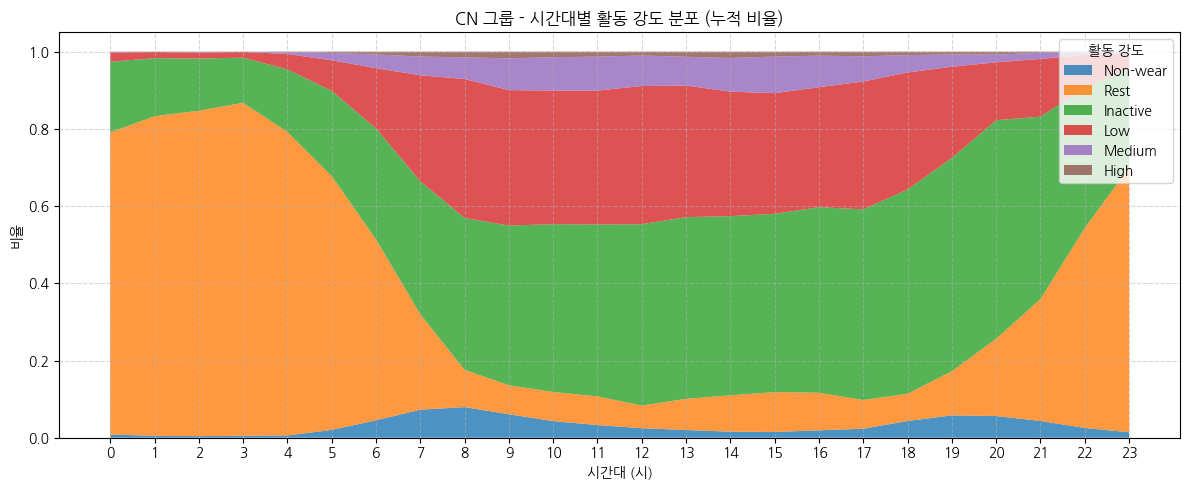

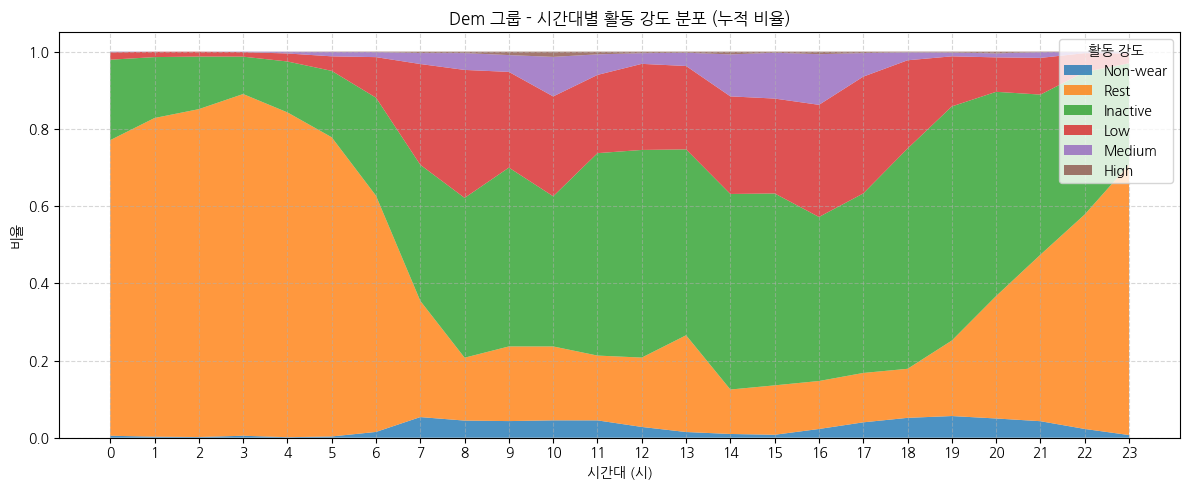

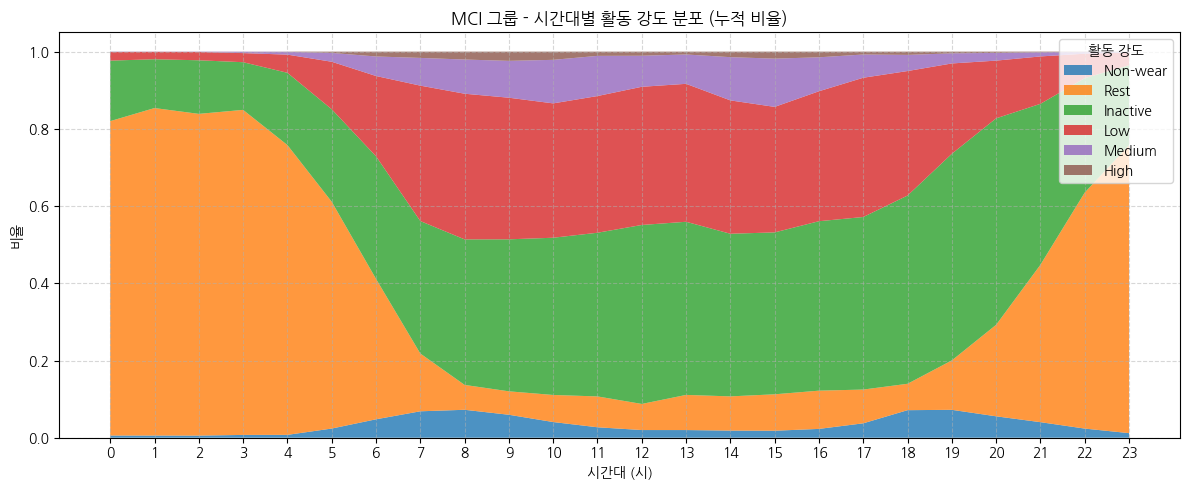

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_activity_class_by_hour(df, class_col="activity_class_5min", group_col="DIAG_NM", time_col="activity_day_start"):
    records = []

    for _, row in df.iterrows():
        group = row[group_col]
        raw = row[class_col]
        start_time = pd.to_datetime(row[time_col], errors='coerce')

        if isinstance(raw, str) and not pd.isna(start_time):
            try:
                classes = [int(x) for x in raw.split("/") if x.isdigit()]
                for i, c in enumerate(classes):
                    minute = i * 5
                    hour = (start_time + pd.Timedelta(minutes=minute)).hour
                    records.append({
                        "group": group,
                        "hour": hour,
                        "class": c
                    })
            except:
                continue

    long_df = pd.DataFrame(records)

    # ÏãúÍ∞ÑÎ≥Ñ class ÎπÑÏú® Í≥ÑÏÇ∞
    counts = (
        long_df
        .groupby(["group", "hour", "class"])
        .size()
        .reset_index(name="count")
    )

    total_counts = counts.groupby(["group", "hour"])["count"].transform("sum")
    counts["pct"] = counts["count"] / total_counts

    class_labels = {
        0: "Non-wear", 1: "Rest", 2: "Inactive",
        3: "Low", 4: "Medium", 5: "High"
    }

    # Í∑∏Î£πÎ≥Ñ ÏãúÍ∞ÅÌôî
    for group in counts["group"].unique():
        pivot_df = (
            counts[counts["group"] == group]
            .pivot(index="hour", columns="class", values="pct")
            .fillna(0)
            .sort_index()
        )
        class_order = sorted(pivot_df.columns)
        pivot_df = pivot_df[class_order]

        plt.figure(figsize=(12, 5))
        plt.stackplot(
            pivot_df.index,
            [pivot_df[c] for c in class_order],
            labels=[class_labels.get(c, f"Class {c}") for c in class_order],
            alpha=0.8
        )
        plt.title(f"{group} Í∑∏Î£π - ÏãúÍ∞ÑÎåÄÎ≥Ñ ÌôúÎèô Í∞ïÎèÑ Î∂ÑÌè¨ (ÎàÑÏ†Å ÎπÑÏú®)")
        plt.xlabel("ÏãúÍ∞ÑÎåÄ (Ïãú)")
        plt.ylabel("ÎπÑÏú®")
        plt.legend(loc="upper right", title="ÌôúÎèô Í∞ïÎèÑ")
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_activity_class_by_hour(df)

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62858/494747368.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


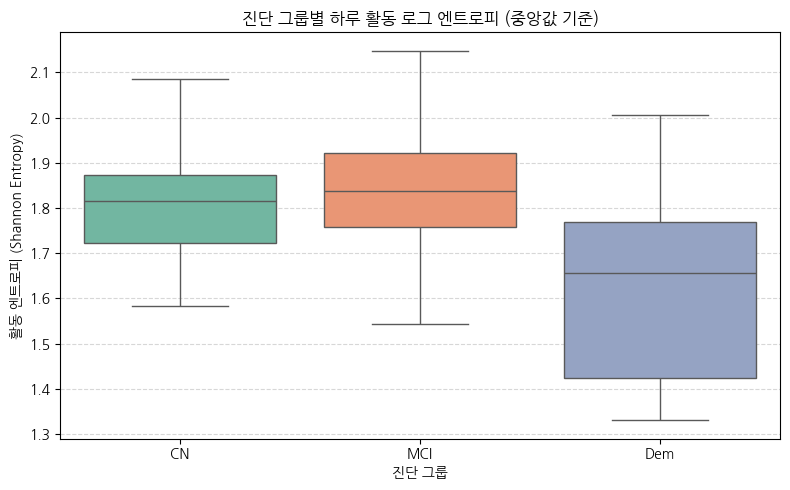

In [159]:
from collections import Counter
from scipy.stats import entropy
import numpy as np

def compute_activity_entropy(activity_str):
    if not isinstance(activity_str, str):
        return np.nan
    values = [int(x) for x in activity_str.split("/") if x.isdigit()]
    if len(values) == 0:
        return np.nan
    freq = Counter(values)
    prob = [count / len(values) for count in freq.values()]
    return entropy(prob, base=2)  # base=2 for bits

df["activity_entropy"] = df["activity_class_5min"].apply(compute_activity_entropy)

entropy_summary = df.groupby("EMAIL").agg({
    "activity_entropy": "median",
    "DIAG_NM": "first"
}).reset_index()

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=entropy_summary,
    x="DIAG_NM",
    y="activity_entropy",
    order=["CN", "MCI", "Dem"],
    palette="Set2",
    showfliers=False
)
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ ÌïòÎ£® ÌôúÎèô Î°úÍ∑∏ ÏóîÌä∏Î°úÌîº (Ï§ëÏïôÍ∞í Í∏∞Ï§Ä)")
plt.xlabel("ÏßÑÎã® Í∑∏Î£π")
plt.ylabel("ÌôúÎèô ÏóîÌä∏Î°úÌîº (Shannon Entropy)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- ÏπòÎß§ -> ÏùºÏÉÅ ÌôúÎèô Ìå®ÌÑ¥Ïùò Îã®Ï°∞Î°úÏõÄ

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_62858/2474324460.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


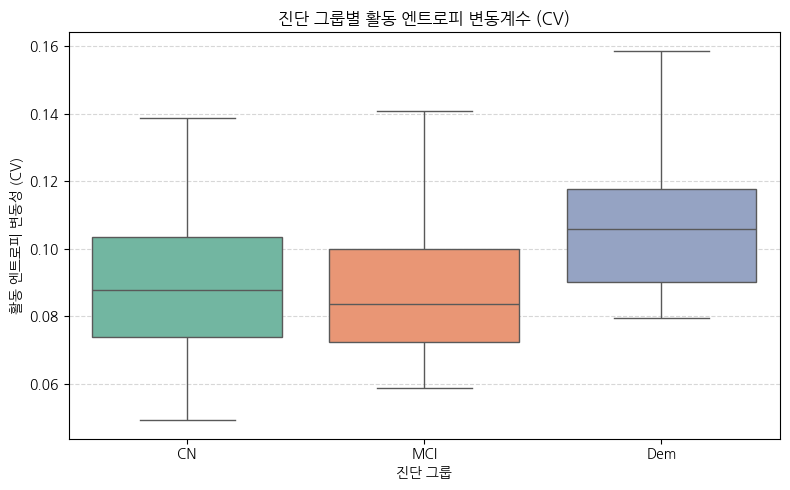

In [160]:
# 1. ÌïòÎ£® Îã®ÏúÑ ÏóîÌä∏Î°úÌîº Í≥ÑÏÇ∞
df["activity_entropy"] = df["activity_class_5min"].apply(compute_activity_entropy)

# 2. Í∞úÏù∏Î≥Ñ ÏóîÌä∏Î°úÌîº ÌèâÍ∑†, ÌëúÏ§ÄÌé∏Ï∞®, Î≥ÄÎèôÍ≥ÑÏàò Í≥ÑÏÇ∞
entropy_variation = (
    df.groupby("EMAIL")["activity_entropy"]
    .agg(["mean", "std"])
    .reset_index()
)
entropy_variation["cv_entropy"] = entropy_variation["std"] / entropy_variation["mean"]

# 3. DIAG_NM Î≥ëÌï©
entropy_variation = entropy_variation.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(),
    on="EMAIL", how="left"
)

# 4. ÏãúÍ∞ÅÌôî (boxplot)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=entropy_variation,
    x="DIAG_NM",
    y="cv_entropy",
    order=["CN", "MCI", "Dem"],
    palette="Set2",
    showfliers=False
)
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ ÌôúÎèô ÏóîÌä∏Î°úÌîº Î≥ÄÎèôÍ≥ÑÏàò (CV)")
plt.xlabel("ÏßÑÎã® Í∑∏Î£π")
plt.ylabel("ÌôúÎèô ÏóîÌä∏Î°úÌîº Î≥ÄÎèôÏÑ± (CV)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

- MCIÏùò ÌôúÎèôÌå®ÌÑ¥Ïù¥ Ïò§ÌûàÎ†§ ÏïàÏ†ïÏ†Å

# activity_rest 

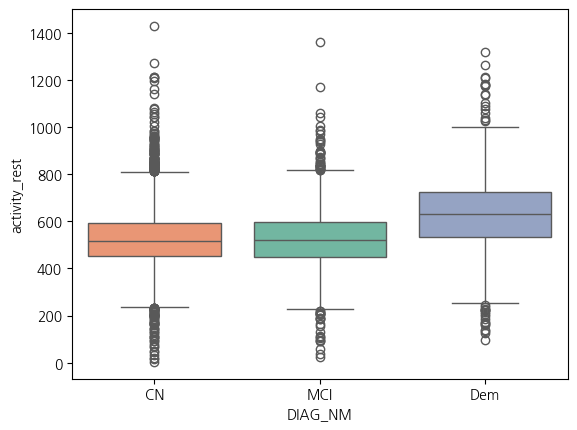

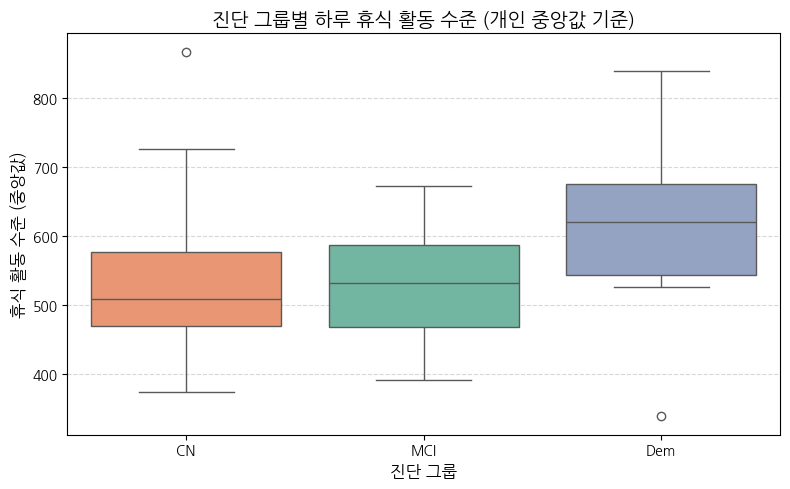

In [166]:
sns.boxplot(data=df, x='DIAG_NM', y='activity_rest', 
            hue='DIAG_NM', palette='Set2',
            order=['CN', 'MCI', 'Dem'])

activity_rest_median = (
    df.groupby("EMAIL")["activity_rest"]
    .median()
    .reset_index(name="median_activity_rest")
)

# 2. ÏßÑÎã®Î™Ö Î≥ëÌï©
activity_rest_median = activity_rest_median.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL", how="left"
)

# 3. ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=activity_rest_median,
    x="DIAG_NM",
    y="median_activity_rest",
    order=["CN", "MCI", "Dem"],
    hue="DIAG_NM",
    palette="Set2"
)
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ ÌïòÎ£® Ìú¥Ïãù ÌôúÎèô ÏàòÏ§Ä (Í∞úÏù∏ Ï§ëÏïôÍ∞í Í∏∞Ï§Ä)", fontsize=14)
plt.xlabel("ÏßÑÎã® Í∑∏Î£π", fontsize=12)
plt.ylabel("Ìú¥Ïãù ÌôúÎèô ÏàòÏ§Ä (Ï§ëÏïôÍ∞í)", fontsize=12)
plt.grid(True, axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# activity_high

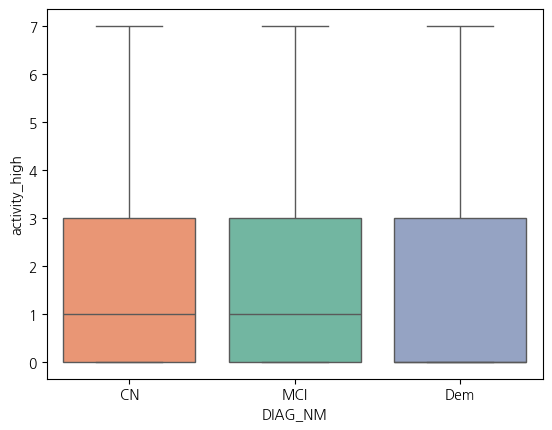

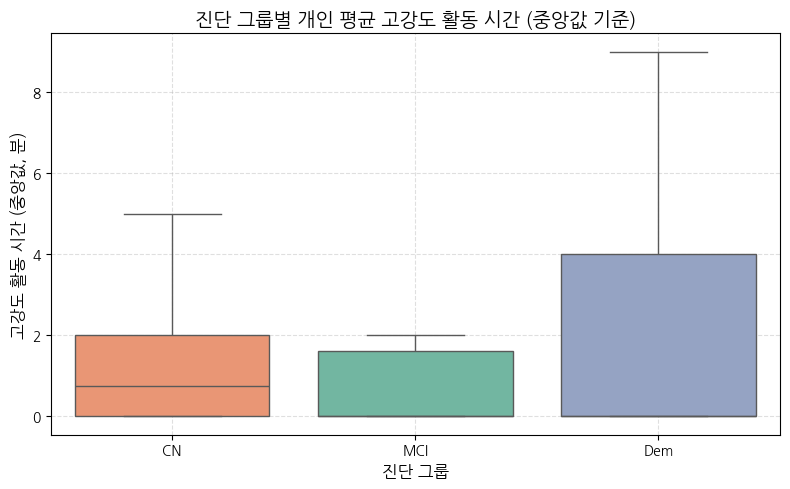

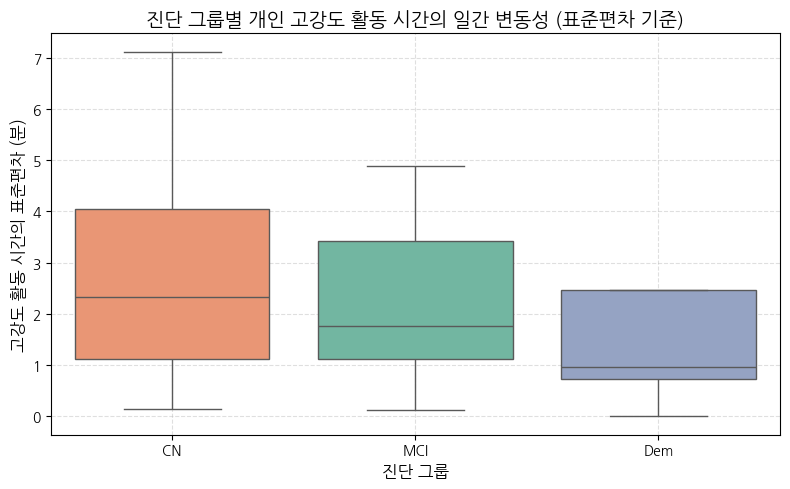

In [187]:
sns.boxplot(data=df, x='DIAG_NM', hue='DIAG_NM', palette='Set2',
            y='activity_high', order=['CN', 'MCI', 'Dem'], showfliers=False)

activity_high_median = (
    df.groupby("EMAIL")["activity_high"]
    .median()
    .reset_index(name="median_activity_high")
)

# 2. ÏßÑÎã®Î™Ö Î≥ëÌï©
activity_high_median = activity_high_median.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL", how="left"
)

# ‚úÖ Ï§ëÏïôÍ∞í ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=activity_high_median,
    x="DIAG_NM",
    y="median_activity_high",
    order=["CN", "MCI", "Dem"],
    hue="DIAG_NM",
    palette="Set2", showfliers=False
)
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ Í∞úÏù∏ ÌèâÍ∑† Í≥†Í∞ïÎèÑ ÌôúÎèô ÏãúÍ∞Ñ (Ï§ëÏïôÍ∞í Í∏∞Ï§Ä)", fontsize=14)
plt.xlabel("ÏßÑÎã® Í∑∏Î£π", fontsize=12)
plt.ylabel("Í≥†Í∞ïÎèÑ ÌôúÎèô ÏãúÍ∞Ñ (Ï§ëÏïôÍ∞í, Î∂Ñ)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

activity_high_std = (
    df.groupby("EMAIL")["activity_high"]
    .std()
    .reset_index(name="std_activity_high")
)

# 2. ÏßÑÎã®Î™Ö Î≥ëÌï©
activity_high_std = activity_high_std.merge(
    df[["EMAIL", "DIAG_NM"]].drop_duplicates(), on="EMAIL", how="left"
)

# ‚úÖ ÌëúÏ§ÄÌé∏Ï∞® ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=activity_high_std,
    x="DIAG_NM",
    y="std_activity_high",
    order=["CN", "MCI", "Dem"],
    hue="DIAG_NM",
    palette="Set2", showfliers=False
)
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ Í∞úÏù∏ Í≥†Í∞ïÎèÑ ÌôúÎèô ÏãúÍ∞ÑÏùò ÏùºÍ∞Ñ Î≥ÄÎèôÏÑ± (ÌëúÏ§ÄÌé∏Ï∞® Í∏∞Ï§Ä)", fontsize=14)
plt.xlabel("ÏßÑÎã® Í∑∏Î£π", fontsize=12)
plt.ylabel("Í≥†Í∞ïÎèÑ ÌôúÎèô ÏãúÍ∞ÑÏùò ÌëúÏ§ÄÌé∏Ï∞® (Î∂Ñ)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# sleep_hr_lowest

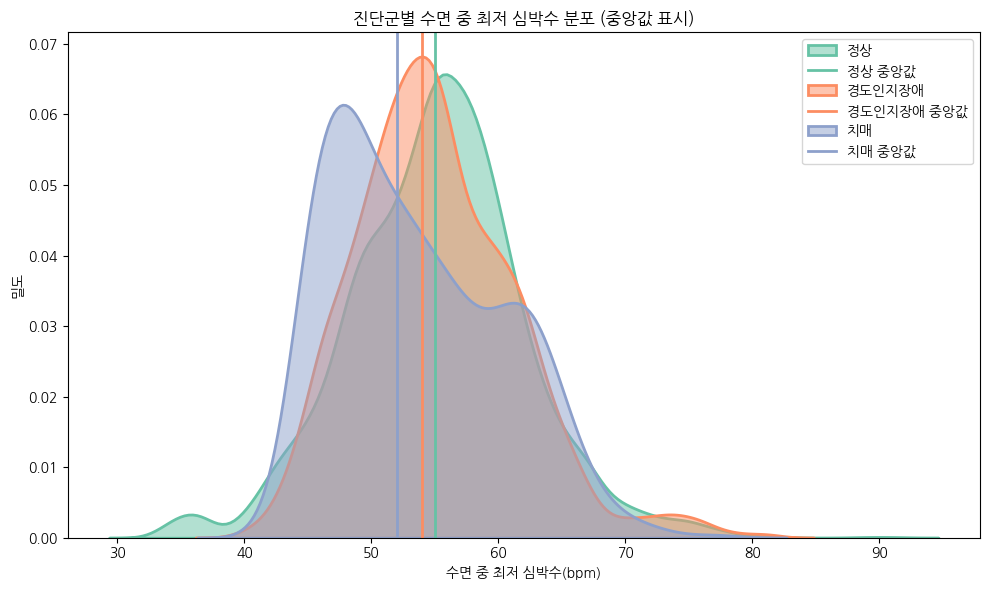

In [190]:
# Set2 ÏÉâÏÉÅ (CN, MCI, Dem Ïàú)
colors = sns.color_palette("Set2")
cn_color = colors[0]  # Greenish
mci_color = colors[1]  # Orange
dem_color = colors[2]  # Bluish

plt.figure(figsize=(10, 6))

# CN
sns.kdeplot(data=df[df["DIAG_NM"] == "CN"], x="sleep_hr_lowest", label="Ï†ïÏÉÅ", fill=True, linewidth=2, color=cn_color, alpha=0.5)
cn_median = df[df["DIAG_NM"] == "CN"]["sleep_hr_lowest"].median()
plt.axvline(cn_median, color=cn_color, linestyle="-", linewidth=2, label="Ï†ïÏÉÅ Ï§ëÏïôÍ∞í")

# MCI
sns.kdeplot(data=df[df["DIAG_NM"] == "MCI"], x="sleep_hr_lowest", label="Í≤ΩÎèÑÏù∏ÏßÄÏû•Ïï†", fill=True, linewidth=2, color=mci_color, alpha=0.5)
mci_median = df[df["DIAG_NM"] == "MCI"]["sleep_hr_lowest"].median()
plt.axvline(mci_median, color=mci_color, linestyle="-", linewidth=2, label="Í≤ΩÎèÑÏù∏ÏßÄÏû•Ïï† Ï§ëÏïôÍ∞í")

# Dem
sns.kdeplot(data=df[df["DIAG_NM"] == "Dem"], x="sleep_hr_lowest", label="ÏπòÎß§", fill=True, linewidth=2, color=dem_color, alpha=0.5)
dem_median = df[df["DIAG_NM"] == "Dem"]["sleep_hr_lowest"].median()
plt.axvline(dem_median, color=dem_color, linestyle="-", linewidth=2, label="ÏπòÎß§ Ï§ëÏïôÍ∞í")


# Í∏∞ÌÉÄ ÏÑ§Ï†ï
plt.title("ÏßÑÎã®Íµ∞Î≥Ñ ÏàòÎ©¥ Ï§ë ÏµúÏ†Ä Ïã¨Î∞ïÏàò Î∂ÑÌè¨ (Ï§ëÏïôÍ∞í ÌëúÏãú)")
plt.xlabel("ÏàòÎ©¥ Ï§ë ÏµúÏ†Ä Ïã¨Î∞ïÏàò(bpm)")
plt.ylabel("Î∞ÄÎèÑ")
plt.legend()
plt.tight_layout()
plt.show()

- Ïù∏ÏßÄÍ∏∞Îä•Ïù¥ Ï†ÄÌïòÎê†ÏàòÎ°ù ÏàòÎ©¥ Ï§ë ÏµúÏ†Ä Ïã¨Î∞ïÏàòÍ∞Ä ÎÇÆÏïÑÏßÄÎäî Í≤ΩÌñ•

In [192]:
# Î¨∏ÏûêÏó¥ ‚Üí Î¶¨Ïä§Ìä∏ ÌååÏã± Ìï®Ïàò
def parse_hr_list(s):
    try:
        return ast.literal_eval(s) if isinstance(s, str) else []
    except:
        return []

df["hr_list"] = df["sleep_hr_5min_interpolated"].apply(parse_hr_list)

# sleep_time_to_hr_lowest

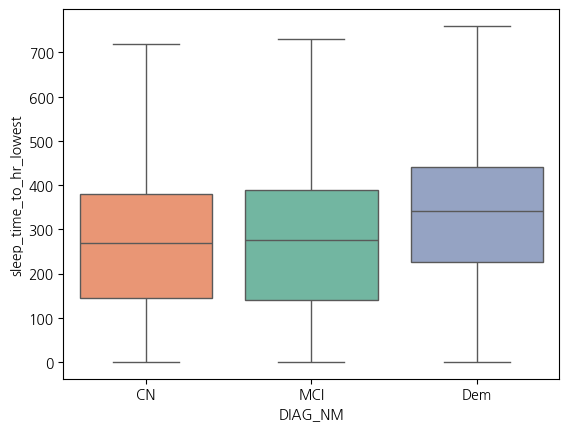

In [198]:
sns.boxplot(
    data=df,
    x='DIAG_NM',
    y='sleep_time_to_hr_lowest',
    order=['CN', 'MCI', 'Dem'],
    hue='DIAG_NM',
    palette="Set2",
    showfliers=False
)
plt.show()

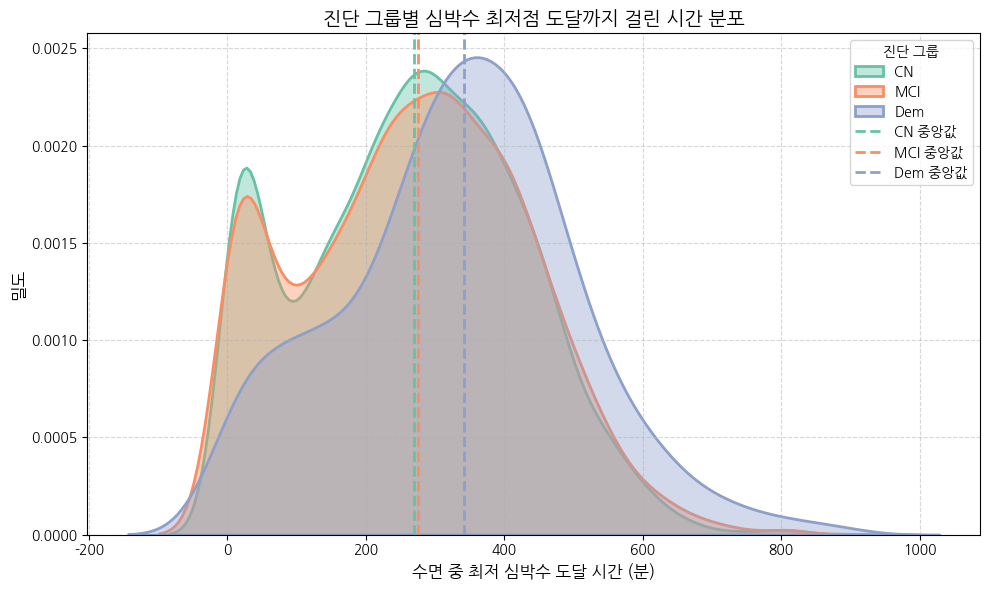

In [197]:
plt.figure(figsize=(10, 6))

# KDE plot for each diagnostic group
palette = sns.color_palette("Set2")
for i, group in enumerate(["CN", "MCI", "Dem"]):
    sns.kdeplot(
        data=df[df["DIAG_NM"] == group],
        x="sleep_time_to_hr_lowest",
        label=group,
        fill=True,
        alpha=0.4,
        linewidth=2,
        color=palette[i]
    )

for i, group in enumerate(["CN", "MCI", "Dem"]):
    median_val = df[df["DIAG_NM"] == group]["sleep_time_to_hr_lowest"].median()
    plt.axvline(median_val, color=palette[i], linestyle="--", linewidth=2, label=f"{group} Ï§ëÏïôÍ∞í")

# Plot settings
plt.title("ÏßÑÎã® Í∑∏Î£πÎ≥Ñ Ïã¨Î∞ïÏàò ÏµúÏ†ÄÏ†ê ÎèÑÎã¨ÍπåÏßÄ Í±∏Î¶∞ ÏãúÍ∞Ñ Î∂ÑÌè¨", fontsize=14)
plt.xlabel("ÏàòÎ©¥ Ï§ë ÏµúÏ†Ä Ïã¨Î∞ïÏàò ÎèÑÎã¨ ÏãúÍ∞Ñ (Î∂Ñ)", fontsize=12)
plt.ylabel("Î∞ÄÎèÑ", fontsize=12)
plt.legend(title="ÏßÑÎã® Í∑∏Î£π")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# sleep_hr_average

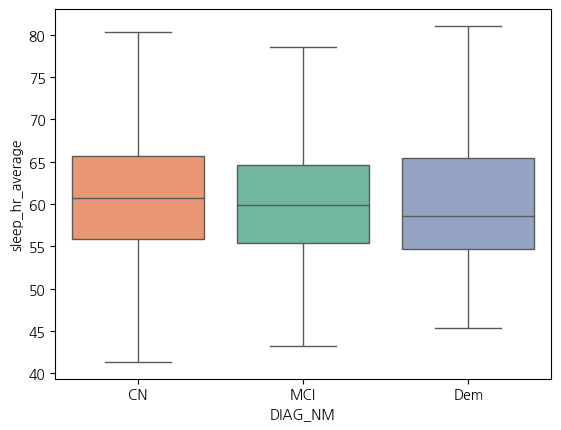

In [199]:
sns.boxplot(
    data=df,
    x='DIAG_NM',
    y='sleep_hr_average',
    order=['CN', 'MCI', 'Dem'],
    hue='DIAG_NM',
    palette="Set2",
    showfliers=False
)
plt.show()